In [31]:
from lenscarf import n0n1_iterative as n01

import numpy as np

import matplotlib.pyplot as plt

import camb
from camb import model, initialpower
from camb import correlations, config
from camb._config import lensing_method_flat_corr, lensing_method_curv_corr

In [10]:
cls_unl = np.load("cls_unl.npy", allow_pickle = True).take(0)
cls_len = np.load("cls_len.npy", allow_pickle = True).take(0)
cls_grad = np.load("cls_grad.npy", allow_pickle = True).take(0)
fidcls_noise = np.load("fidcls_noise.npy", allow_pickle = True).take(0)

In [44]:
itermax = 10
qe_key = "ptt"
lmin_ivf, lmax_ivf, lmax_qlm = 10, 4000, 5000

In [45]:
delensed = n01.get_delcls(qe_key, itermax, cls_unl, cls_unl, fidcls_noise, fidcls_noise, lmin_ivf, lmax_ivf, lmax_qlm)

 [00:00:06]  ---------> 90%


In [46]:
delcls = delensed[0]

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_67544/921926251.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(d["tt"]/base)


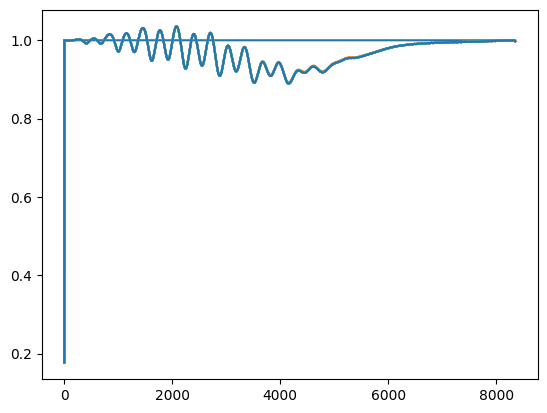

In [47]:
for i, d in enumerate(delcls):
    if i == 0:
        base = d["tt"]
    plt.plot(d["tt"]/base)

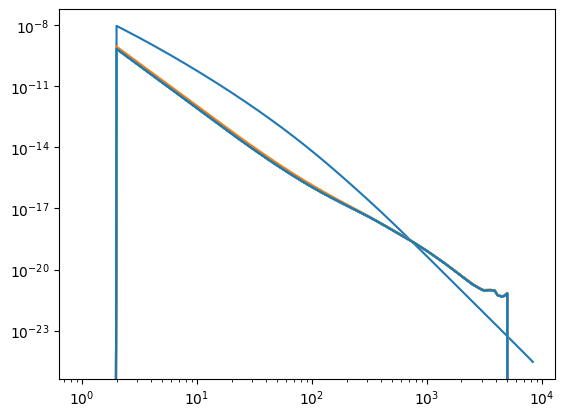

In [48]:
for i, d in enumerate(delcls):
    plt.loglog(d["pp"])

In [49]:
#Use flat sky, get gradient spectra
#pars =camb.set_params(H0=None, cosmomc_theta =0.010411,lmax=4200, lens_potential_accuracy=1)
lmax=8000
pars = camb.CAMBparams()
#print pars.Recomb.RECFAST_fudge

pars.set_cosmology(H0=67, ombh2=0.022445, omch2=0.1212, mnu=0)
pars.InitPower.set_params(As=2.1265e-09, ns=0.96)

# reionization and recombination 
pars.Reion.use_optical_depth = True
pars.Reion.optical_depth = 0.0925
pars.Reion.delta_redshift = 0.5
pars.Recomb.RECFAST_fudge = 1.14

# accuracy
pars.set_for_lmax(lmax+200, lens_potential_accuracy=4)

#non linearity
pars.NonLinear = model.NonLinear_both
pars.NonLinearModel.halofit_version = 'takahashi'
pars.Accuracy.AccurateBB = True #need this to avoid small-scale ringing
#config.lensing_method=lensing_method_curv_corr
#%time data1=camb.get_results(pars)
config.lensing_method=lensing_method_flat_corr # default

%time data=camb.get_results(pars)


CPU times: user 17.9 s, sys: 240 ms, total: 18.2 s
Wall time: 3.59 s


In [50]:
basecamb = data.get_lensed_gradient_cls(CMB_unit = 'muK', raw_cl = True)

In [51]:
casi = {}

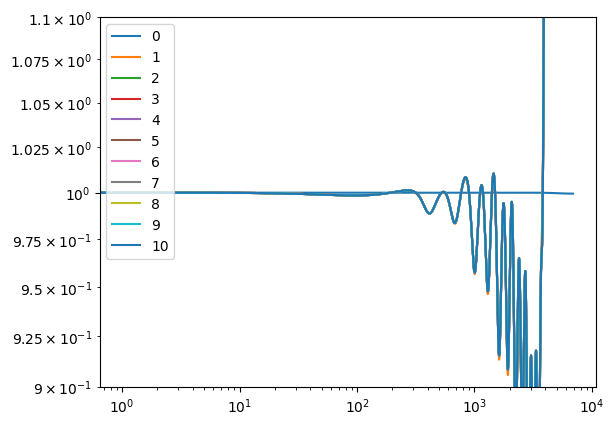

In [52]:
for i, d in enumerate(delcls):
    ls = np.arange(0, len(d["pp"]))
    clpp = d["pp"]*(ls*(ls+1))**2./2/np.pi
    caso = data.get_lensed_gradient_cls(CMB_unit = 'muK', raw_cl = True, clpp = clpp)
    casi[i] = caso
    plt.loglog(caso[2:,0]/basecamb[2:,0], label = i)
#plt.plot(basecamb[2:,0], label = "basecamb")
plt.ylim(0.9, 1.1)
plt.legend()

In [53]:
np.save("casi.npy", casi)